In [ ]:
!pip install numpy pandas matplotlib scikit-learn tensorflow joblib

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preprocessing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Deep_Learning_Assignment/SriLanka_Weather_Dataset.csv')

# View basic info
print("Initial shape:", df.shape)
print(df.head())

Initial shape: (147480, 24)
         time  weathercode  temperature_2m_max  temperature_2m_min  \
0  2010-01-01            2                30.0                22.7   
1  2010-01-02           51                29.9                23.5   
2  2010-01-03           51                29.5                23.2   
3  2010-01-04            2                28.9                21.9   
4  2010-01-05            1                28.1                21.3   

   temperature_2m_mean  apparent_temperature_max  apparent_temperature_min  \
0                 26.1                      34.4                      25.2   
1                 26.2                      33.8                      26.2   
2                 26.0                      34.3                      26.3   
3                 25.3                      31.6                      23.4   
4                 24.5                      30.1                      23.1   

   apparent_temperature_mean           sunrise            sunset  ...  \
0        

In [4]:
# Clean rows with missing values
df = df.dropna()
df = df.reset_index(drop=True)

### Feature Selection

In [5]:
# Let's predict 'temperature_2m_mean' using weather-related features

# Drop irrelevant columns
drop_cols = ['city', 'country', 'latitude', 'longitude', 'elevation', 'time', 'sunrise', 'sunset']
features = [
    'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean',
    'apparent_temperature_mean', 'precipitation_sum',
    'windspeed_10m_max', 'windgusts_10m_max', 'et0_fao_evapotranspiration'
]

data = df[features]

### Normalization

In [6]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

scaled_df = pd.DataFrame(scaled_data, columns=features, index=df.index)

### Create Sequences for LSTM

In [7]:
def create_sequences(dataset, look_back=30):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i+look_back, :])  # past 30 days
        y.append(dataset[i+look_back, 2])    # predict temperature_2m_mean
    return np.array(X), np.array(y)

look_back = 30  # 30 days history
X, y = create_sequences(scaled_data, look_back)

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (147450, 30, 8)
Shape of y: (147450,)


### Train-Test Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)
print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

Train samples: 117960, Test samples: 29490


In [9]:
# Save the scaler for inverse transformation later -
########## NOTE
import joblib
joblib.dump(scaler, 'scaler.save')

['scaler.save']

# LSTM Model Creation and Training

In [10]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

### Define Model Architecture

In [11]:
model = Sequential([
    # LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True, ),
    Dropout(0.2),

    LSTM(32, return_sequences=False),
    Dropout(0.2),

    Dense(16, activation='relu'),
    Dense(1)  # output: predicted temperature_2m_mean (normalized)
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,649 (123.63 KB)

 Trainable params: 31,649 (123.63 KB)

 Non-trainable params: 0 (0.00 B)

### Define Callbacks

In [13]:
# early_stop = EarlyStopping(
#     monitor='val_loss',
#     patience=10,
#     restore_best_weights=True
# )

### Train the Model

In [15]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 106s 29ms/step - loss: 0.0016 - val_loss: 0.0038
Epoch 2/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 146s 30ms/step - loss: 0.0012 - val_loss: 0.0030
Epoch 3/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 108s 29ms/step - loss: 0.0011 - val_loss: 0.0035
Epoch 4/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 105s 29ms/step - loss: 0.0010 - val_loss: 0.0040
Epoch 5/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 105s 29ms/step - loss: 0.0010 - val_loss: 0.0042
Epoch 6/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 140s 28ms/step - loss: 0.0010 - val_loss: 0.0036
Epoch 7/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 105s 29ms/step - loss: 0.0010 - val_loss: 0.0040
Epoch 8/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 105s 29ms/step - loss: 9.8685e-04 - val_loss: 0.0043
Epoch 9/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 106s 29ms/step - loss: 9.8543e-04 - val_loss: 0.0036
Epoch 10/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 140s 28ms/step - loss: 9.7999e-04 - val_loss: 0.0044
Epoch 11/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 144s 29ms/step - loss: 9.6412e-04 

### Evaluate Model Performance

In [16]:
test_loss = model.evaluate(X_test, y_test)
print(f"\nTest MSE: {test_loss:.6f}")
print(f"Test RMSE: {np.sqrt(test_loss):.6f}")

922/922 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0028

✅ Test MSE: 0.002965
✅ Test RMSE: 0.054448


### Plot Training History

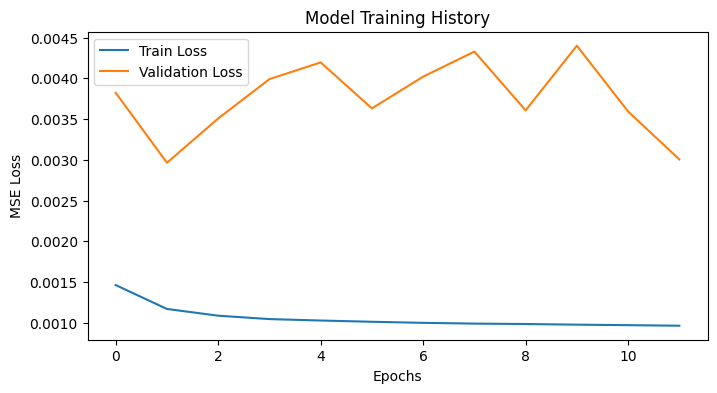

In [17]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

### Save Model

In [18]:
model.save('lstm_temperature_forecast.h5')
print("Model saved successfully.")

✅ Model saved successfully.
